# Meta-Training SNNs using MAML

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from collections import OrderedDict

from yingyang.dataset import YinYangDataset

import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import argparse
from torchviz import make_dot

In [2]:
%load_ext autoreload
%autoreload 2

## Data and Config

In [3]:
from eventprop.config import get_flat_dict_from_nested

In [4]:
data_config = {
    "seed": 42,
    "dataset": "ying_yang",
    "deterministic": True,
    "meta_batch_size": 10,
    "encoding": "latency",
    "T": 50,
    "dt": 1e-3,
    "t_min": 0,
    "data_folder": "../../../data/",
    "n_samples_per_task": 100,
    "n_tasks_per_split": 64,
    "dataset_size" : 1000,
}
data_args = argparse.Namespace(**data_config)

In [5]:
torch.manual_seed(data_config["seed"])
np.random.seed(data_config["seed"])
random.seed(data_config["seed"])

data_config["dataset"] = data_config["dataset"]
if data_config["deterministic"]:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
torch.cuda.is_available()

True

## Rotation Ying Yang data for Meta Learning

In [7]:
from yingyang.meta_dataset import YingYangMetaDataset
from torchmeta.utils.data import BatchMetaDataLoader
from eventprop.training import encode_data
from torchmeta.transforms import ClassSplitter
from torchvision.transforms import Compose
from torch.utils.data import RandomSampler

In [8]:
encode_tranform = lambda s: (encode_data(s[0], data_args), s[1])

dataset_split = lambda d: ClassSplitter(
    d,
    num_train_per_class=data_config["dataset_size"],
    num_test_per_class=data_config["dataset_size"],
    shuffle=False,
)

meta_train_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_train=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split
)
meta_val_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_val=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)
meta_test_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_test=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)

# meta_train_dataset, meta_val_dataset, meta_test_dataset = [
#     ClassSplitter(
#         d,
#         num_train_per_class=data_config["n_samples_per_task"],
#         num_test_per_class=data_config["n_samples_per_task"],
#         shuffle=False,
#     )
#     for d in [meta_train_dataset, meta_val_dataset, meta_test_dataset]
# ]

meta_train_dataloader = BatchMetaDataLoader(
    meta_train_dataset,
    data_config["meta_batch_size"],
    shuffle=True,
    num_workers=0,
)

meta_val_dataloader = BatchMetaDataLoader(
    meta_val_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

meta_test_dataloader = BatchMetaDataLoader(
    meta_test_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

In [9]:
batch = next(iter(meta_train_dataloader))
batch["train"][0].shape

torch.Size([10, 1000, 50, 1, 5])

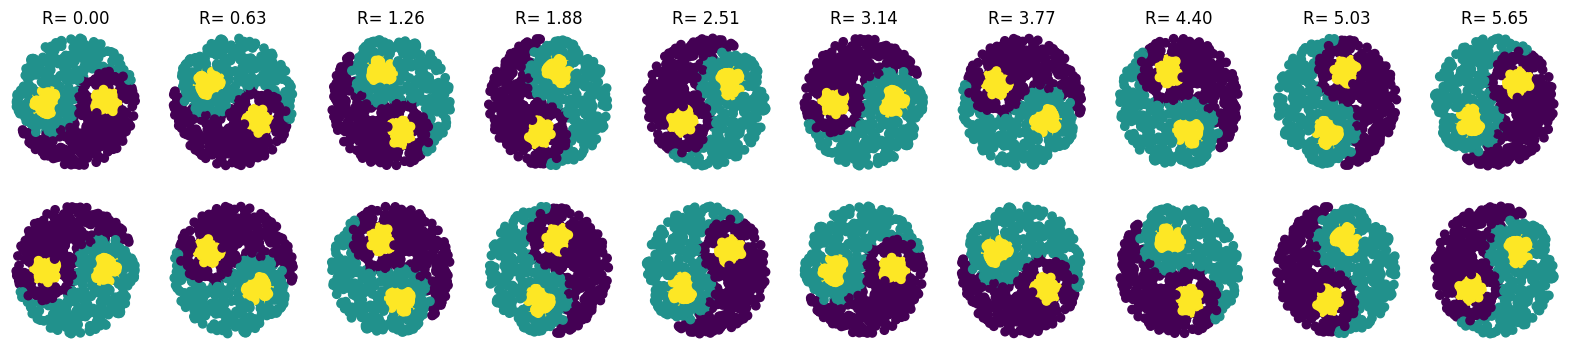

In [10]:
plot_rotations = np.linspace(0, 2 * np.pi, 10, endpoint=False)
fig, axs = plt.subplots(
    2,
    len(plot_rotations),
    figsize=(2 * len(plot_rotations), 4),
    sharex=True,
    sharey=True,
)
for r_axs, r in zip(axs.T, plot_rotations):
    train_dataset = YinYangDataset(size=1000, seed=data_config["seed"], rotation=r)
    for i, ax in enumerate(r_axs):
        data = train_dataset.data[:, 2 * i : 2 * i + 2]
        ax.scatter(data[:, 0], data[:, 1], c=train_dataset.targets)
        ax.axis("off")
        ax.grid(True)
        # ax.set_title(f"Min Max = {data.min():.2f} {data.max():.2f}")
        if i == 0:
            ax.set_title(f"R= {r:.2f}")

## Models

In [11]:
from eventprop.models import Meta_SNN, SpikeCELoss
import torch.nn as nn
from snn_maml.plasticity_rules import custom_sgd

In [12]:
model_config = {
    "model_type": "eventprop",
    "snn": {
        "T": data_config["T"],
        "dt": data_config["dt"],
        "tau_m": 20e-3,
        "tau_s": 5e-3,
    },
    "weights": {
        "init_mode": "kaiming_both",
        # "scale_0_mu": 3,
        # "scale_0_sigma": 1.5,
        # "scale_1_mu": 5,
        # "scale_1_sigma": 2.5,
        "scale": 6,
        "n_hid": 120,
        "resolve_silent": False,
        "dropout": 0.0,
    },
    # "device": (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")),
    "device": torch.device("cpu"),
}

n_ins = {"mnist": 784, "ying_yang": 5 if data_config["encoding"] == "latency" else 4}
n_outs = {"mnist": 10, "ying_yang": 3}

In [13]:
training_config = {
    "num_epochs": 20,
    "loss": "ce_temporal",
    "alpha": 3e-3,
    "xi": 0.5,
    "beta": 6.4,
    "n_tests": 3,
    "exclude_equal": False,
    "do_train": True,
    "do_test": False,
}

## Inner Loop Optim
optim_config = {
    "lr": 5e-3,
    "weight_decay": 0.0,
    "optimizer": "adam",
    "gamma": 0.95,
}

maml_config = {
    "num_shots": 100,
    "num_shots_test": 1000,
    "first_order": False,
    "meta-lr": 1e-4,
    "inner-lr": 100,
    "learn_step_size": False,
    "meta-gamma": 0.95,
}

default_config = {
    "data": data_config,
    "model": model_config,
    "training": training_config,
    "optim": optim_config,
    "maml": maml_config,
}
config = get_flat_dict_from_nested(default_config)
args = argparse.Namespace(**config)

In [14]:
dims = [n_ins[config["dataset"]]]
if config["n_hid"] is not None and isinstance(config["n_hid"], list):
    dims.extend(config["n_hid"])
elif isinstance(config["n_hid"], int):
    dims.append(config["n_hid"])
dims.append(n_outs[config["dataset"]])

model = Meta_SNN(dims, **config).to(config["device"])
init_params = OrderedDict(model.meta_named_parameters()).copy()
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
loss_fn = SpikeCELoss(alpha=config["alpha"], xi=config["xi"], beta=config["beta"])

In [58]:
if True:
    batch = next(iter(meta_train_dataloader))
    # torch.autograd.set_detect_anomaly(True)
    all_losses = []
    all_accs = []
    pbar = tqdm(range(10))
    params = None
    desc = {}

    for _ in pbar:

        mean_acc_before = []
        mean_acc_after = []

        i = 0
        batch = next(iter(meta_train_dataloader))
        for train_inputs, train_targets, test_inputs, test_targets in zip(
            *batch["train"], *batch["test"]
        ):
            params = None

            # test
            model.eval()
            mean_loss = 0
            for input, target in zip(test_inputs[:], test_targets):
                input, target = input.to(config["device"]), target.to(config["device"])
                out = model(input, params=None)

                first_spikes = model.first_spike_fn(out)
                mean_acc_before.append((first_spikes.argmin(dim=1) == target).float().mean().item())

            # train
            model.train()
            for input, target in zip(train_inputs[:], train_targets):
                # input, target = train_inputs.to(config["device"]), train_targets.to(config["device"])
                input, target = input.to(config["device"]), target.to(config["device"])
                out = model(input, params=params)
                loss = loss_fn(out, target)[0]
                # optimizer.zero_grad()
                # loss.backward()
                # optimizer.step()
                params = custom_sgd(
                    model,
                    loss,
                    step_size=config["inner-lr"],
                    params=params,
                    first_order=False,
                    custom_update_fn=None,
                    save_graph=False,
                )

                all_losses.append(loss.item())

                first_spikes = model.first_spike_fn(out)
                acc = (first_spikes.argmin(dim=1) == target).float().mean().item()

                all_accs.append(acc)
                desc.update(
                    {
                        "Train_Loss": np.mean(all_losses[-100:]),
                        "Train_Acc": np.mean(all_accs[-100:]),
                        "Iter": f"{i} / {len(batch['train'][0]) * len(train_inputs)}",
                    }
                )
                pbar.set_postfix(desc)
                i += 1

            # test
            model.eval()
            mean_loss = 0
            for input, target in zip(test_inputs[:], test_targets):
                # input, target = test_inputs.to(config["device"]), test_targets.to(config["device"])
                input, target = input.to(config["device"]), target.to(config["device"])
                out = model(input, params=params)
                loss = loss_fn(out, target)[0]
                mean_loss += loss
                first_spikes = model.first_spike_fn(out)
                mean_acc_after.append((first_spikes.argmin(dim=1) == target).float().mean().item())

            mean_loss /= len(test_inputs)

            optimizer.zero_grad()
            # make_dot(loss, params=dict(model.initial_params)).render("graphs/last_loss")
            # make_dot(mean_loss, params=dict(model.initial_params)).render("graphs/mean_loss")
            mean_loss.backward()
            optimizer.step()

            desc.update(
                {"| Test_Acc": f"{np.mean(mean_acc_before):.2f} -> {np.mean(mean_acc_after):.2f}"}
            )

            pbar.set_postfix(
                desc,
            )

        i=0
        batch = next(iter(meta_test_dataloader))
            
        for train_inputs, train_targets, test_inputs, test_targets in zip(
            *batch["train"], *batch["test"]
        ):
            params = None

            # test
            model.eval()
            mean_loss = 0
            for input, target in zip(test_inputs[:], test_targets):
                input, target = input.to(config["device"]), target.to(config["device"])
                out = model(input, params=None)

                first_spikes = model.first_spike_fn(out)
                mean_acc_before.append((first_spikes.argmin(dim=1) == target).float().mean().item())

            # train
            for input, target in zip(train_inputs[:], train_targets):
                # input, target = train_inputs.to(config["device"]), train_targets.to(config["device"])
                input, target = input.to(config["device"]), target.to(config["device"])
                out = model(input, params=params)
                loss = loss_fn(out, target)[0]
                # optimizer.zero_grad()
                # loss.backward()
                # optimizer.step()
                params = custom_sgd(
                    model,
                    loss,
                    step_size=config["inner-lr"],
                    params=params,
                    first_order=True,
                    custom_update_fn=None,
                    save_graph=False,
                )

                all_losses.append(loss.item())

                first_spikes = model.first_spike_fn(out)
                acc = (first_spikes.argmin(dim=1) == target).float().mean().item()

                all_accs.append(acc)
                desc.update(
                    {
                        "Iter": f"{i} / {len(batch['train'][0]) * len(train_inputs)}",
                    }
                )
                pbar.set_postfix(desc)
                i += 1

                # test
                mean_loss = 0
                for input, target in zip(test_inputs[:], test_targets):
                    # input, target = test_inputs.to(config["device"]), test_targets.to(config["device"])
                    input, target = input.to(config["device"]), target.to(config["device"])
                    out = model(input, params=params)
                    loss = loss_fn(out, target)[0]
                    mean_loss += loss
                    first_spikes = model.first_spike_fn(out)
                    mean_acc_after.append((first_spikes.argmin(dim=1) == target).float().mean().item())

                mean_loss /= len(test_inputs)

                desc.update(
                    {"| Val_Acc": f"{np.mean(mean_acc_before):.2f} -> {np.mean(mean_acc_after):.2f}"}
                )

                pbar.set_postfix(
                    desc,
                )


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [16]:
from snn_maml.maml import ModelAgnosticMetaLearning
from torchviz import make_dot

In [18]:
meta_optimizer = torch.optim.Adam(model.parameters(), lr=maml_config["meta-lr"])
if maml_config["meta-gamma"] is not None:
    meta_scheduler = torch.optim.lr_scheduler.ExponentialLR(
        meta_optimizer, gamma=maml_config["meta-gamma"]
    )
    
metalearner = ModelAgnosticMetaLearning(
    model,
    meta_optimizer,
    step_size=maml_config["inner-lr"],
    first_order=maml_config["first_order"],
    loss_function=SpikeCELoss(xi=config["xi"]),
    device=config["device"],
    num_adaptation_samples=maml_config["num_shots"],
)

In [19]:
all_test = np.zeros(args.num_epochs)
all_train = np.zeros(args.num_epochs)
epoch_desc = "Epoch {{0: <{0}d}}".format(1 + int(np.log10(args.num_epochs)))
results_accuracy_after = []

for epoch in range(10):
    print(epoch, meta_scheduler.get_last_lr())
    if args.do_train:
        results_train = metalearner.train(
            meta_train_dataloader,
            max_batches=1,
            desc="Training",
            leave=False,
            epoch=epoch,
        )  # ,
        # deltaw=args.deltaw)

        if results_train is not None:
            all_train[epoch] = np.mean(results_train["accuracies_after"])
            
    results = metalearner.evaluate(
        meta_val_dataloader,
        max_batches=1,
        desc=epoch_desc.format(epoch + 1),
    )

    if "accuracies_after" in results:
        results_accuracy_after.append(results["accuracies_after"])
        # if not args.no_log:
        #     wandb.log(
        #         {"accuracies_after/": results["accuracies_after"], "epoch": epoch}
        #     )

    if args.do_test:
        results_test = metalearner.evaluate(
            meta_test_dataloader,
            max_batches=10,
            desc=epoch_desc.format(epoch + 1),
        )  # ,
        # deltaw=args.deltaw)

        print("Test results: ", np.mean(results_test["accuracies_after"]))

        all_test[epoch] = np.mean(results_test["accuracies_after"])

0 [0.0001]


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 : 100%|██████████| 1/1 [00:11<00:00, 11.58s/it, after in-loop=0.4039, before in-loop=0.3402, loss=1.1909]     


1 [0.0001]


Epoch 2 : 100%|██████████| 1/1 [00:10<00:00, 10.27s/it, after in-loop=0.3904, before in-loop=0.3402, loss=1.1773]      


2 [0.0001]


Epoch 3 : 100%|██████████| 1/1 [00:10<00:00, 10.09s/it, after in-loop=0.4012, before in-loop=0.3402, loss=1.1190]     


3 [0.0001]


Epoch 4 : 100%|██████████| 1/1 [00:10<00:00, 10.34s/it, after in-loop=0.4019, before in-loop=0.3402, loss=1.1588]     


4 [0.0001]


Epoch 5 : 100%|██████████| 1/1 [00:11<00:00, 11.75s/it, after in-loop=0.4129, before in-loop=0.3402, loss=1.1320]    


5 [0.0001]


Epoch 6 :   0%|          | 0/1 [00:05<?, ?it/s, task=5/10, Test Acc=0.3630000054836273 -> 0.4390000104904175]         


KeyboardInterrupt: 